# 第三章：分类
## MNIST数据集
本章学习用的数据集为70000张手写的数字图片，被称为机器学习领域的Hello World，新的分类算法往往会在MNIST上进行测试

sklearn提供饿了许多功能帮忙下载流行的 数据集，其中就包括了MNIST，通过如下代码来获取数据集

获取的数据存储在$HOME/scikit_learn_data目录下

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


由于图片是28\*28的，故总共包含了784个特征，图片由于是黑白的，每个特征都有0-255表示从黑到白，可以存在一个28\*28的二维数组里面，然后使用**matplotlib.imshow()**打印出来


对应的数字：5


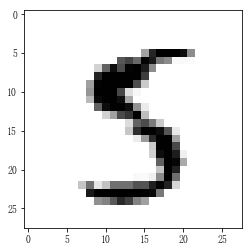

In [47]:
import random
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
a = random.randint(0,69999)
some_digit = X[a] # 抓取其中随机一个数据
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = "binary")
print("对应的数字："+str(y[a]))#显示对应的标签

In [4]:
y = y.astype(np.uint8)#将y（标签）的数据类型转化为标准的整数类型列表
print(y)
print(len(y))

[5 0 4 ... 4 5 6]
70000


**MNIST库中已经将数据分成了训练集和测试集**，其中前六万张图片是训练集，后一万张是测试集

```python
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]
```
数据基本的准备完成了，那么接下来...

## 训练二元分类器

先简化问题——只尝试识别一个数字，比如数字5，则只有两个类别，5和非5

一个好的初始选择：随机梯度下降(SGD)分类器，使用**sklearn.linear_model.SGDClassifier**即可。我们先创建一个SGDClassifier并且在整个训练集上进行训练

**y_train_5&y_test_5:布尔类型：对于训练集/测试集对应位置元素是否为5的真值结果列表**

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# 自动创建一个分类器实例，然后将数据集放入实例中拟合，有的时候max_iter和tol超参数默认值会不一样
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [6]:
sgd_clf.predict([some_digit])#结合上面的随机抽样可以验证正确性，上面代码块随机出5的数据时结果为True，否则为False

array([False])

## 性能测量
### 使用交叉验证测量准确率
同第二章的，交叉验证是一个评估模型的好方法

    补充：
    有时我们想控制更多一些，则不再使用sklearn.cross_val_score，而是可以自己实现一个：

In [7]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# # K折分层抽样

# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = y_train_5[train_index]
#     X_test_fold = X_train[test_index]
#     y_test_fold = y_train_5[test_index]

#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred)) #0.9669  0.91625  0.96785

In [8]:
#使用原本的交叉验证
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#array([0.95035, 0.96035, 0.9604 ])

看样子准确率在0.9+?但这是不够科学的！
**因为只有10%是True，即使一直猜False都有90%的准确率**
所以需要一个更好的评估方法

### 混淆矩阵(Confusion Matrix)
还是刚刚的问题，我们现在想知道数字3和5的混淆次数

计算混淆矩阵需要有一组预测结果，可以通过测试集来预测，但是最好不要先动他。作为替代，可以使用**cross_val_predict**函数

**cross_val_score & cross_value_predict**一个返回的是评估的分数，一个返回的是对每个折叠的预测

二元混淆矩阵：True/False+Positive/Negative

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [10]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train_5, y_train_pred)# 混淆矩阵两个参数，均为true/false的列表，通过两个数据比对生成混淆矩阵
print(mat)
mat[0][0] += mat[0][1]
mat[1][1]+= mat[1][0]
mat[0][1] = 0
mat[1][0] = 0
print(mat)

[[53892   687]
 [ 1891  3530]]
[[54579     0]
 [    0  5421]]


通过混淆矩阵，可以获取到一些分类器的指标：
###  精度与召回率
**精度**
$$精度 = \frac{TP}{TP+FP}$$
**召回率**
$$召回率 = \frac{TP}{TP+FN}$$

sklearn提供了多种计算分类器指标的函数，其中包括了精度和召回率(**precision_score, recall_score**)

精度和召回率的实际意义：精度：判断是阳性的时候是真阳性的概率；召回率：真阳性能被判断出来的概率

In [11]:
from sklearn.metrics import precision_score, recall_score

print("precision: "+str(precision_score(y_train_5, y_train_pred)))
print("recall: "+str(recall_score(y_train_5, y_train_pred)))

precision: 0.8370879772350012
recall: 0.6511713705958311


**F1分数：**精度和召回率的调和平均值（谐波平均值）

$$F1 = \frac{2}{\frac{1}{精度}+\frac{1}{召回率}}$$

In [12]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))
print(f1_score(y_train_pred, y_train_5))# 说明精度和召回率在矩阵上的意义具有对称性，当真值和测试集互换时，精度和召回率互换

0.7325171197343846
0.7325171197343846


### 精度/召回率权衡
理解如何做到精度和召回率的权衡，我们需要理解SGDClassifier的决策模式：对每个分实例，会给予决策函数计算出一个**分值**，如果大于**阈值**则判断为正类，否则判断为负类**所以，在不改变决策函数的情况下，精度和召回率只能是此消彼长的**

sklearn并不允许直接设置阈值，但可以访问**决策分数**，不是调用predict()方法，而是调用decision_function()方法，该方法返回的是每个实力的分数，然后可以根据这些分数来使用任意阈值进行预测。可以对不同的阈值进行分析选择最理想的阈值来自行完成精度和召回率的权衡

### 补充：关于此项目中的数据结构...
有些参数是不是有些疑问？比如图片信息最终是以什么格式存储在什么数据结构里的

**ndarray多维数组**：本项目中的数据是个二维数组，黑白图片通过28\*28呈现，但其实存储在一维数组内，然后所有的数据再线性分布，形成二维数组。如**some_digit参数**就是一个一维数组

**sgd_clf决策模型——SGDClassifier类的实例**是对一维数组的决策，但调用许多方法的时候因为这些方法是可以批量处理数据产生结果的，所以传入参数的时候传的是数据的集合，所以呈现的输入的数据结构是二维数组

**SGDClassifier**的阈值设定是0，改变阈值可以通过调整**threshold**来改变（threshold：阈值）

In [13]:
y_scores = sgd_clf.decision_function(X_train)
print("y_scores for all: "+str(y_scores))
y_scores = sgd_clf.decision_function([some_digit])#参数：2维数组，返回值：一个一维数组，所以是[some_digit]，分别为每组数据的评分
print("y_scores for X0 which is 5: "+str(y_scores))

# Aloka获得混淆矩阵的方法（not in book）
threshold = 8000
y_scores = sgd_clf.decision_function(X_train)
print(len(y_scores))
y_train_pred = (y_scores > threshold)
# 我们来看看调整后的混淆矩阵
mat = confusion_matrix(y_train_5, y_train_pred)# 混淆矩阵两个参数，均为true/false的列表，通过两个数据比对生成混淆矩阵
print(mat)


y_scores for all: [  2164.22030239  -5897.37359354 -13489.14805779 ...   6007.43513003
   -695.89564908  -3991.49590678]
y_scores for X0 which is 5: [-2018.57756266]
60000
[[54570     9]
 [ 4725   696]]


用matplotlib来绘制精度和召回率关于阈值变化的变化趋势

55672
0.9000705384434516
recall_90_precision: 0.7061427780852241
threshold_90_precision: 2123.562046995018


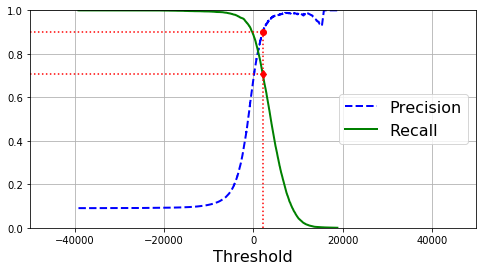

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


# 使用np.argmax来寻找到满足括号内条件的第一个索引
print(np.argmax(precisions >=0.9))
print(precisions[55672])
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print("recall_90_precision: "+str(recall_90_precision))
print("threshold_90_precision: "+str(threshold_90_precision))

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "rd")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

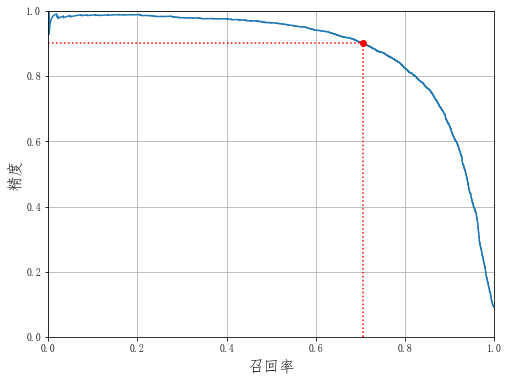

In [15]:
# 绘制精度/召回率曲线
plt.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)# ("b-", linewidth=2)
    plt.xlabel("召回率", fontsize=16)
    plt.ylabel("精度", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [16]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
#threshold_90_precision #2123.562046995018


### ROC曲线
ROC曲线（**受试者工作特征曲线**）与精度/召回率曲线非常相似，但绘制的是**真正类率和假正类率（真正类率即召回率，假正类率为FPR，即1-TNR，TNR是正确分为负类的比率，也成为特异度）**

绘制ROC曲线，可以用**roc_curve()**
函数计算多种阈值的TPR和FPR（因为二者变化是随着阈值改变的）

https://blog.csdn.net/Titan0427/article/details/79356290

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
# 返回三个数组，分别为每个数据的阈值，假正率，真正率以及此数据对应的阈值
# print(fpr)
# print(tpr)
# print(thresholds)

以此为基础开始绘图


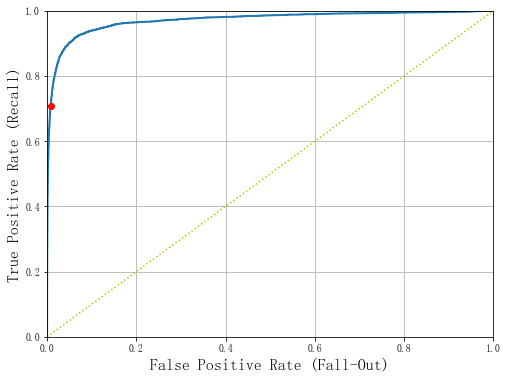

In [18]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'y:') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot(fpr_90, recall_90_precision, "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()

上图中黄色的虚线有特别的意义：表示**纯随机分类器的ROC曲线**所以离这条线越远越好

有一种方法是侧量曲线下面积AUC，纯随机为0.5，面积越大越好


In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9709618248430906

看似还不错？其实还不够！可以更接近！
### 我们现在训练一个新的分类器：RandomForestClassifier（随机森林分类器）
不再用随机梯度下降分类器，而是用随机森林法

In [20]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")


In [21]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
# array类别：xxx = xxx[y, :] 选取第y行的数值， xxx = xxx[:, y] 选取第y列的数值
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

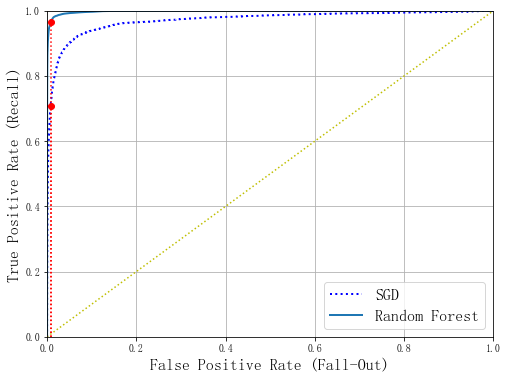

In [22]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

可以注意到随机森林的ROC曲线明显由于SGD（随机梯度）

为了验证这一点，计算一下ROC AUC分数

In [23]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 多类分类器
可以区分两个以上的类

有些算法可以直接处理多个类，如**随机森林分类器**或者**朴素贝叶斯分类器**；但有一些严格的二元分类器，如**支持向量机分类器或线性分类器**，但有多重策略可以用二元分类器实现多类分类器

1. 使用n个二元分类器，看决策分数哪个最高来实现n类分类（**OVR-one vs rest**）
2. 使用n(n-1)/2个二元分类器，虽然分类器更多，但处理问题的规模更小（**OVO**）

Sklearn可以检测到你尝试使用二元分类算法实现多类分类，他会自动选择运行OVR还是OVO

使用**sklearn.svm.SVC类**来试试SVM分类器：


In [24]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
# 注意，这里至训练了前1000个
svm_clf.predict([some_digit])

array([7], dtype=uint8)

In [25]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.93672053,  8.19324105,  4.98585718,  1.87180719,  7.1107916 ,
         0.85998001,  2.88509577,  9.19744483, -0.18355263,  6.01561605]])

#### 强制使用OVO/OVR策略
可以使用OneVsOneClassifier或OneVsRestClassifier类

In [26]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
print(len(ovr_clf.estimators_))
ovr_clf.predict([some_digit])

10


array([7], dtype=uint8)

### 随机梯度下降分类器：也可以完成多种分类
模型拟合&性能测量

In [27]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [28]:
sgd_clf.predict([some_digit])

array([8], dtype=uint8)

In [29]:
# 使用交叉验证来评估出classifier的准确性
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # array([0.87365, 0.85835, 0.8689 ])
# 可以通过数据的缩放来提高准确率


通过对数据的简单缩放，可以有效提高准确率
**StandardScaler**提供了一些方法
https://blog.csdn.net/wzyaiwl/article/details/90549391

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # array([0.8983, 0.891 , 0.9018])

## 误差分析
假设已经找到了一个有潜力的模型，现在就需要找到一些方法对其进行进一步改进，其中一个方法就是分析错误类型

首先使用**cross_val_predict()** 函数，对于训练集整体进行预测，然后调用congusion_matrix()

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
print(y_train_pred)

[3 0 4 ... 5 6 8]


In [32]:
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


关于矩阵数据可视化的处理：
    **使用matplotlib的matshow()来将其变成黑白的图像，二位矩阵很多都能使用这个方法可视化**

变得更多彩？https://blog.csdn.net/baishuiniyaonulia/article/details/81416649
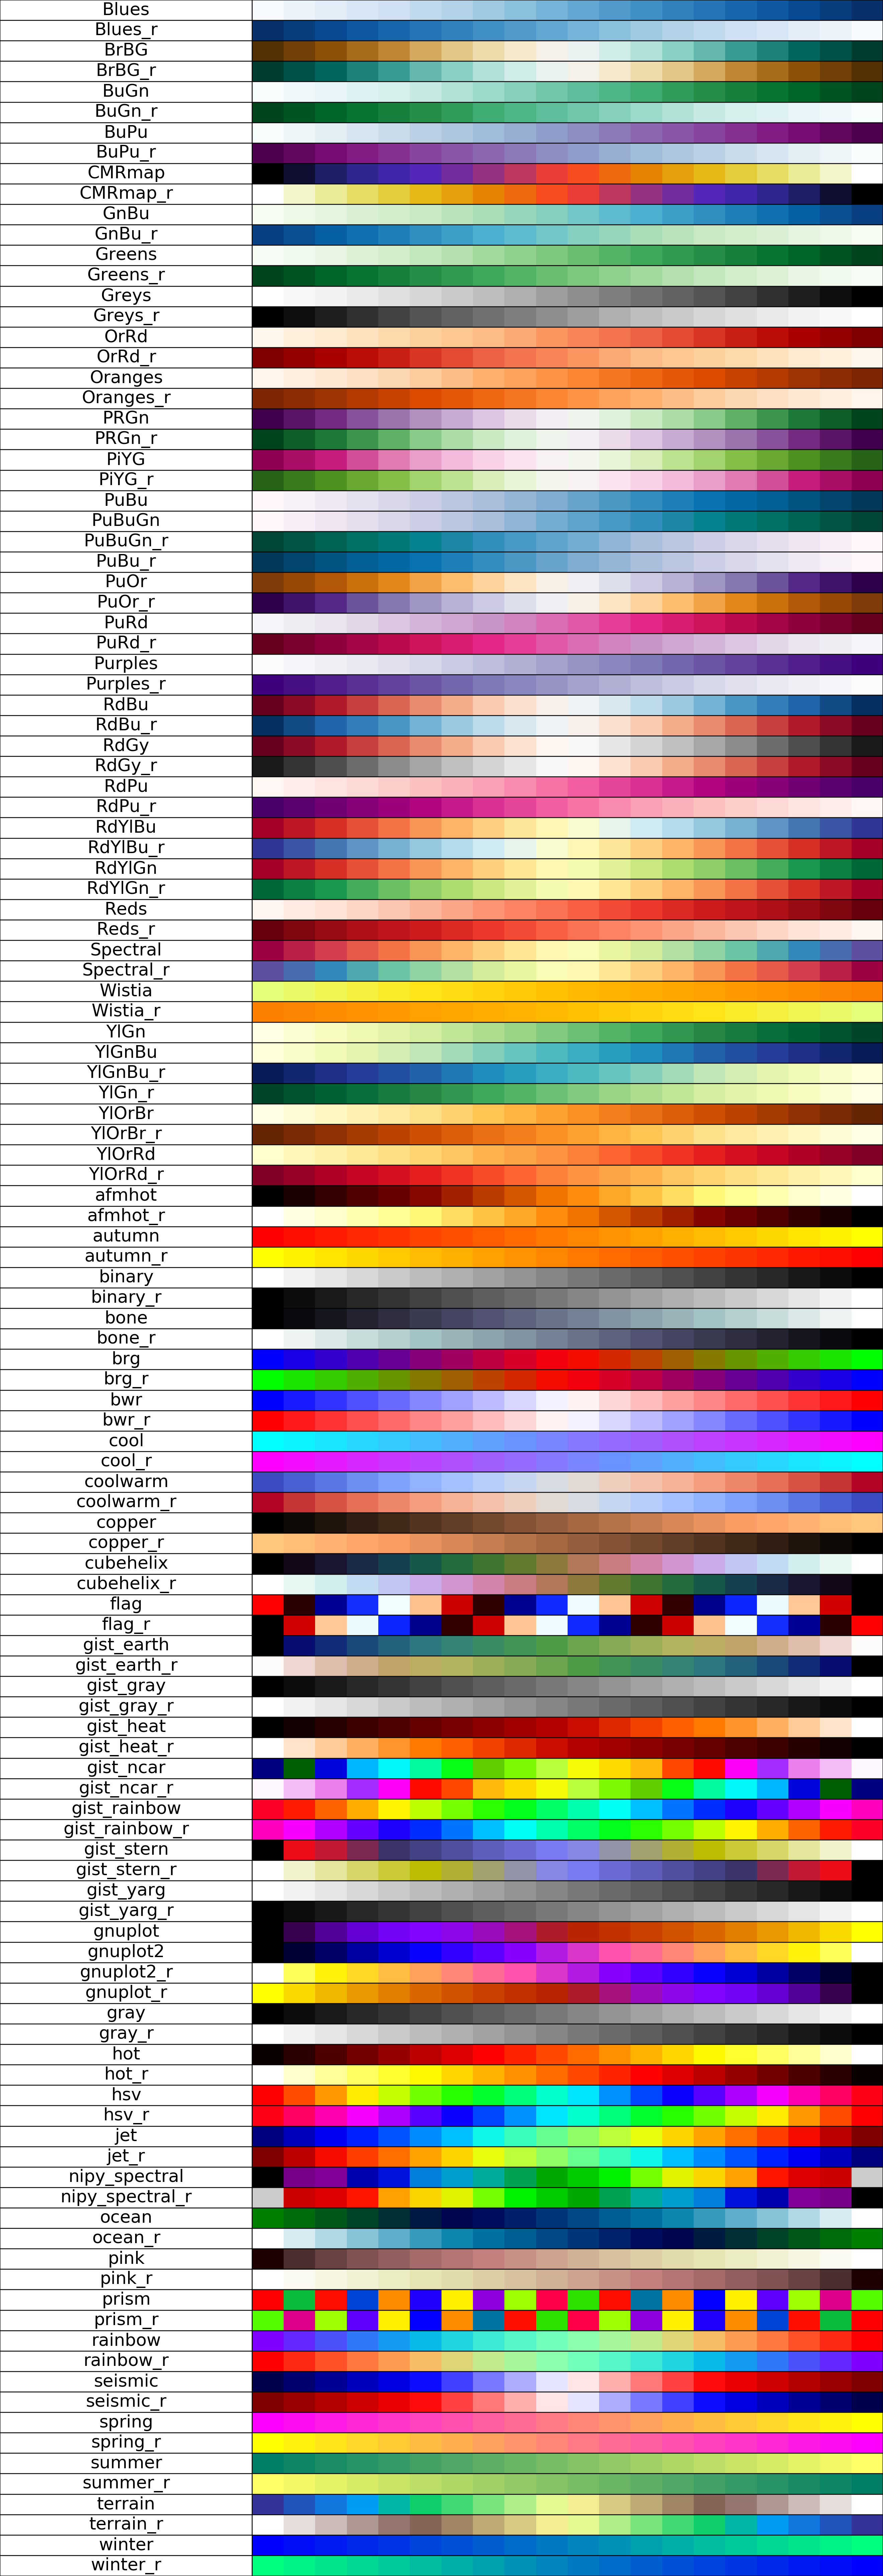
    

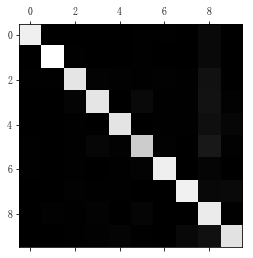

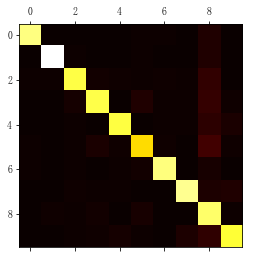

In [33]:
plt.matshow(conf_mx, cmap = plt.cm.Greys_r)# 和gray是一样的
plt.matshow(conf_mx, cmap = plt.cm.hot)
plt.show()

光进行数据统计是不够科学的，需要获得**错误率**而不是错误的绝对值，而且主对角线因为数据量大，整体会显得亮，导致混淆矩阵的错误不突出

所以有要对矩阵进行处理：**计算出每个值除以相应类中的图片数量，并且将对角线清零** 

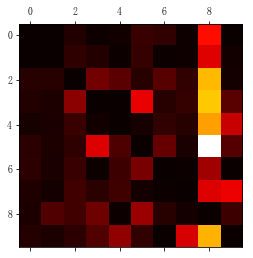

In [34]:
# 混淆矩阵中元素由错误数量变为错误率
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) # 将对角线用0填充，仅显示出错误部分
plt.matshow(norm_conf_mx, cmap=plt.cm.hot)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

### 错误的捕捉
结果分析：每行代表实际类别，每列代表预测类别，行整体比较量说明经常和其他数字混淆，行很暗说明大多数可以被正确分类
分析混淆矩阵可以帮助深入了解如何改进分类器，比如修正数字3和数字5混淆， 第8列整体看起来很亮，说明有许多图片被错误分类为数字8，第9行比较亮，说明数字9经常会和别的数字混淆
例如：1.尝试收集更多这些数字的训练数据 2.开发新特征来改进分类器（闭环数量 ：数字8两个 ，数字9一个，数字6一个，数字5没有） 3.对图片进行预处理



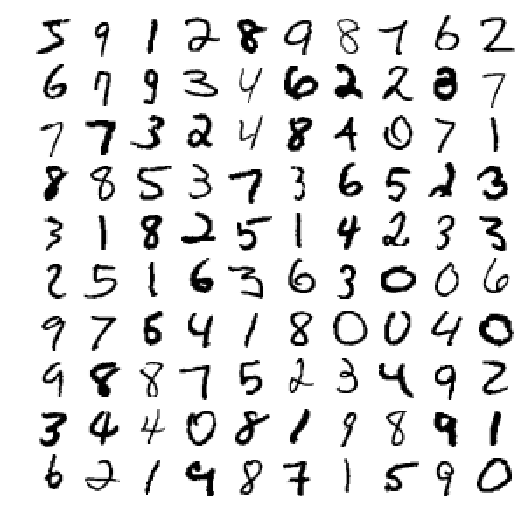

In [35]:

import matplotlib as mpl
 
# 把3和5的预测情况拿出来分析
def plot_digits(instances,images_per_row=10,**options):
    size=28
    # 每一行有一个
    image_pre_row=min(len(instances),images_per_row)
    images=[instances.reshape(size,size) for instances in instances]
    # 有几行
    n_rows=(len(instances)-1) // image_pre_row+1
    row_images=[]
    n_empty=n_rows*image_pre_row-len(instances)
    images.append(np.zeros((size,size*n_empty)))
    for row in range(n_rows):
        # 每一次添加一行
        rimages=images[row*image_pre_row:(row+1)*image_pre_row]
        # 对添加的每一行的额图片左右连接
        row_images.append(np.concatenate(rimages,axis=1))
    # 对添加的每一列图片 上下连接
    image=np.concatenate(row_images,axis=0)
    plt.imshow(image,cmap=mpl.cm.binary,**options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images=np.r_[X[:12000:600],X[13000:30600:600],X[30600:60000:590]]
plot_digits(example_images,images_per_row=10)
plt.show()


In [36]:
cl_a, cl_b = 3,5
y_train[0] = 5
y_train_pred[0] = 3
X_aa = []
X_ab = []
X_ba = []
X_bb = []
for i in range(len(y_train)):
    if((y_train[i] == cl_a) & (y_train_pred[i] == cl_a)):X_aa.append(X_train[i])
    if((y_train[i] == cl_a) & (y_train_pred[i] == cl_b)):X_ab.append(X_train[i])
    if((y_train[i] == cl_b) & (y_train_pred[i] == cl_b)):X_bb.append(X_train[i])
    if((y_train[i] == cl_b) & (y_train_pred[i] == cl_a)):X_ba.append(X_train[i])
np.array(X_aa[:25])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

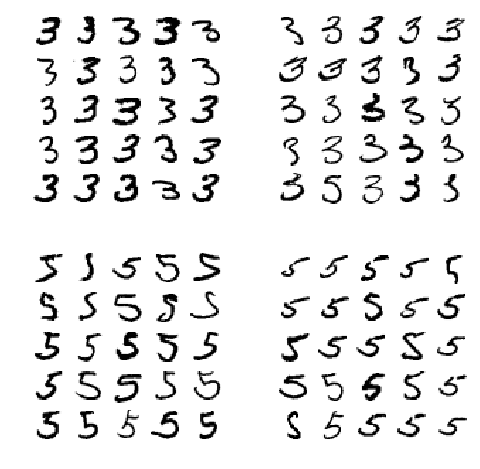

In [78]:

plt.figure(figsize=(8,8))
# np.array()
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
 
plt.show()

## 多标签分类
有些情况下，需要将每个实例分到多个类中（eg：人脸识别中识别合照中的人脸，输出[1,0,1]:有A有C无B）

不如来个简单的实例：**K邻居法分类器** 进行多个分类

In [45]:
from sklearn.neighbors import KNeighborsClassifier
 
# 大于7
y_train_large = ((y_train >= 7))
# 奇数
y_train_odd = (y_train%2 == 1)
# 创建一个KNeighborsClassifier 实例  然后使用多个目标对它进行训练
y_multilabel = np.c_[y_train_large,y_train_odd]
# multilabel: 将两个标签合并，用于后续的拟合以及交叉验证
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [49]:
# 交叉验证时间很久，略掉
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

## 多输出分类
我们即将讨论的最后一种分类任务被叫做“多输出-多类分类”(或者简称为多输出分类)。它是多标签分类的简单泛化，在这里每一个标签可以是多类别的(比如说，它可以有多于两个可能值)。

 为了说明这点，我们**建立一个系统，它可以去除图片当中的噪音。**它将一张混有噪音的图片作为输入，期待它输出一张干净的数字图片，用一个像素强度的数组表示，就像 MNIST 图片那样。注意到这个分类器的输出是多标签的(一个像素一个标签)和每个标签可以有多个值(像素强度取值范围从 0 到 255)。所以它是一个多输出分类系统的例子。
 
 分类与回归之间的界限是模糊的，比如这个例子。按理说，预测一个像素的强度更类似于一个回归任务，而不是一个分类任务。而且，多输出系统不限于分类任务。你甚至可以让你一个系统给每一个样例都输出多个标签，包括类标签和值标签
 
 注意一下几个函数：**plt.imshow**是matplotlib内置函数，可以将一个**二维数组**变成图片输出，而plot_digits是将**一维数组**输出，至于按照什么方式折叠是在**size=** 处设置的； 一维转二维可以用**reshape函数**

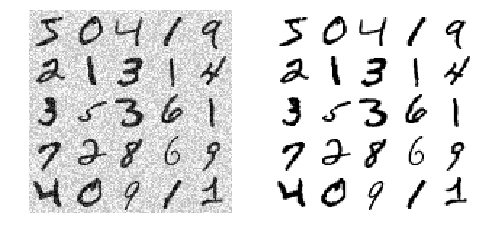

In [70]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
plt.figure(figsize=(8,8))
plt.subplot(121);plot_digits(np.array(X_train_mod[:25]), images_per_row=5)
plt.subplot(122);plot_digits(np.array(y_train_mod[:25]), images_per_row=5)
# imsX = X_train_mod[3].reshape(28,28)
# plt.imshow(imsX, cmap = "binary")

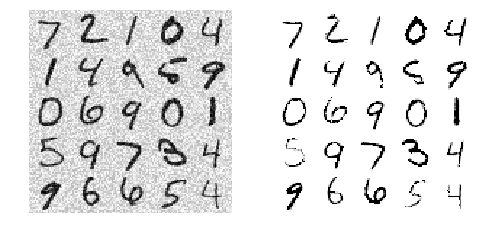

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[:25])
plt.figure(figsize=(8,8))
plt.subplot(121);plot_digits(X_test_mod[:25], images_per_row=5)
plt.subplot(122);plot_digits(clean_digit, images_per_row=5)
# save_fig("cleaned_digit_example_plot")

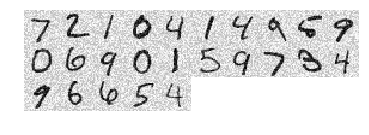

In [75]:
plot_digits(X_test_mod[:25])